In [50]:
import requests
from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()
client = OpenAI()
import matplotlib.pyplot as plt
import json

GROUP_THEM_URL = "http://127.0.0.1:8080/groupthem"

In [53]:
state = requests.get(GROUP_THEM_URL).json()
state

{'guesses': [],
 'available_words': ['edge',
  'vice',
  'milk',
  'windows',
  'office',
  'teams',
  'run',
  'rose',
  'devil',
  'work',
  'jobs',
  'strawbery',
  'mars',
  'function',
  'operate',
  'blonde']}

### WordGuess

In [9]:
todo

{'guesses': [], 'maximum_guesses': 6}

### GroupThem

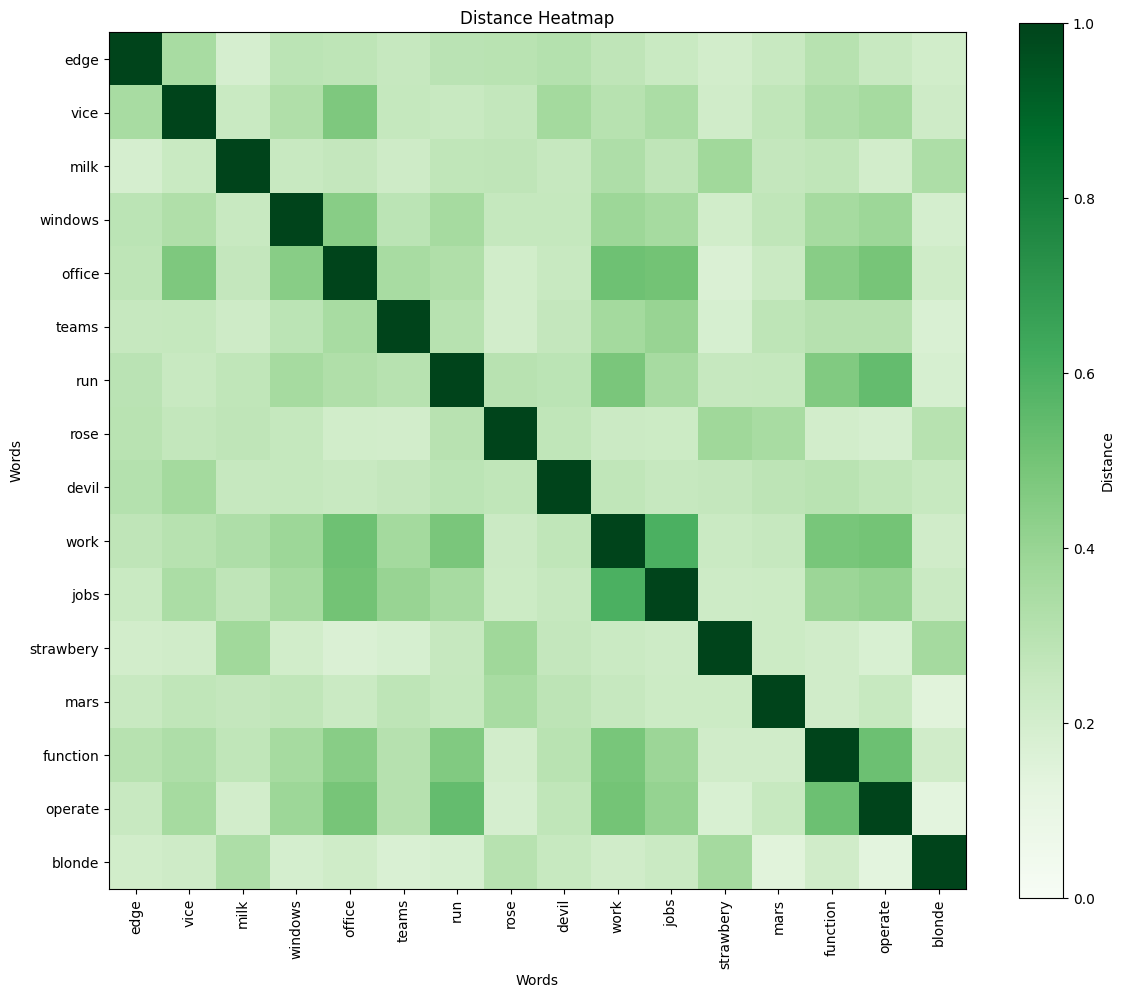

[['work', 'jobs', 'office', 'operate'],
 ['run', 'function', 'windows', 'teams'],
 ['vice', 'devil', 'edge', 'mars'],
 ['rose', 'strawbery', 'blonde', 'milk']]

In [47]:
# Embed all words
state = requests.get(GROUP_THEM_URL).json()
words = state["available_words"]

embeddings = [
    x.embedding for x in client.embeddings.create(
        model="text-embedding-3-large",
        input=state["available_words"]
    ).data
]

amount = len(embeddings)
import numpy as np
# Compare all items to eachother
similarity_matrix = np.zeros((amount, amount))

for i in range(amount):
    for j in range(amount):
        if i != j:
            similarity_matrix[i, j] = np.dot(embeddings[i], embeddings[j])
        else:
            similarity_matrix[i, j] = 1

# Plot the similarity matrix as a grid of squares with word labels
plt.figure(figsize=(12, 10))
plt.imshow(similarity_matrix, cmap='Greens', interpolation='nearest', vmin=0, vmax=1)

# Add color bar to interpret the shading
plt.colorbar(label='Distance')

# Set tick labels to words
plt.xticks(ticks=np.arange(amount), labels=words, rotation=90)
plt.yticks(ticks=np.arange(amount), labels=words)

# Add labels for better readability
plt.title('Distance Heatmap')
plt.xlabel('Words')
plt.ylabel('Words')

# Show plot
plt.tight_layout()
plt.show()


### Group the items
# Create a list of dictionaries with words and their similarities
as_sorted_array = [
    {
        "word": words[i],
        "similarities": sorted(
            [{"word": words[j], "similarity": sim} for j, sim in enumerate(similarity_matrix[i]) if i != j],
            key=lambda x: x["similarity"],
            reverse=True
        )
    }
    for i in range(len(words))
]

# Sort based on the highest similarity
as_sorted_array.sort(key=lambda x: x["similarities"][0]["similarity"], reverse=True)

# Create groups of words based on similarity
groups = []
chosen = set()

for item in as_sorted_array:
    if item["word"] in chosen:
        continue
    
    group = [item["word"]]
    chosen.add(item["word"])
    
    for similar in item["similarities"]:
        if len(group) == 4:
            break
        if similar["word"] not in chosen:
            group.append(similar["word"])
            chosen.add(similar["word"])
    
    groups.append(group)

groups

In [51]:
from collections import defaultdict
from enum import Enum

models = ["gpt-4o", "gpt-4o-2024-08-06", "gpt-4o-mini", "gpt-3.5-turbo"]
schema = '{"reasoning": String, "connections": [String; 4]}'

class Status(Enum):
    WIN = 1
    LOSE = 2
    DROPPED = 3
    UKNWN = 4

result = {model: {"guesses": defaultdict(int)} for model in models}

FREQUENCY_INCREASE = 0
TEMPERATURE_INCREASE = 0
TEMPERATURE_DEFAULT = 1

def process(model: str):
    frequency_penalty = 0
    temperature = TEMPERATURE_DEFAULT
    s = requests.Session()
    state = s.get(GROUP_THEM_URL).json()
    conversation = [
        {"role": "system", "content": "You are a helpful assistant. Create a json object with the connection groups & your reasoning. ### Schema\n" + schema },
        {"role": "user", "content": "Create the mentioned JSON object through trying to find a connection between exactly 4 of these items: " + ", ".join(state["available_words"]) + "."},
    ]
    
    for i in range(10):
        # Ask model to attempt connection
        response = client.chat.completions.create(
            model=model,
            messages=conversation,
            temperature=max(0, min(temperature, 1.2)),
            frequency_penalty=max(0, min(frequency_penalty, 2)),
        ).choices[0].message.content
        
        start = response.find("{")
        end = response.find("}", start)
        
        try:
            json_response = json.loads(response[start:end+1])
        except Exception as e:
            print(response)
            print(e)
            conversation.append({"role": "user", "content": "Invalid JSON object. Please try again following the schema: " + schema})
        
        conversation.append({"role": "assistant", "content": response})
        
        print(f"\n>Guess: {json_response['connections']}\nReasoning: {json_response['reasoning']}")
        # Send connections
        payload = {"guess": json_response["connections"]}
        
        try:
            response = s.post(GROUP_THEM_URL, json=payload)
            if response.status_code != 200:
                
                result[model]["guesses"][Status.DROPPED] += 1
                frequency_penalty += FREQUENCY_INCREASE
                temperature += TEMPERATURE_INCREASE
                if "guess already made" in response.text.lower():
                    conversation.append({"role": "user", "content": "WARNING: This guess was already made"})
                    print("Guess already made")
                    continue
                
                if "not a valid word" in response.text.lower():
                    conversation.append({"role": "user", "content": f"WARNING: {response.text}"})
                    print("Invalid word")
                    continue
                
                if "4 words" in response.text.lower():
                    conversation.append({"role": "user", "content": "WARNING: You must provide exactly 4 words"})
                    print("Invalid amount of words")
                    continue
                
                else:
                    print(f"\n### {response.text}")
                    break
            available_words = response.json()["available_words"]
        except Exception as e:
            print(e)
            break
        
        win = json_response["connections"][0] not in available_words
        print(f"Win: {win}\n")
        if len(available_words) == 0:
            print(f"### You won in {i+1} guesses!")
            result[model]
            break
        else:
            
            if win:
                frequency_penalty = 0
                temperature = TEMPERATURE_DEFAULT
                result[model]["guesses"][Status.WIN] += 1
                conversation = [
                    {"role": "system", "content": "You are a helpful assistant. Create a json object with the connection groups & your reasoning. ### Schema\n" + schema },
                    {"role": "user", "content": "Create the mentioned JSON object through trying to find a connection between exactly 4 of these items: " + ", ".join(available_words) + "."},
                ]
            else:
                frequency_penalty += FREQUENCY_INCREASE
                temperature += TEMPERATURE_INCREASE
                result[model]["guesses"][Status.LOSE] += 1
                conversation.append(
                    {"role": "user", "content": "INCORRECT. Important: Try again with DIFFERENT options."}
                )

for model in models:
    print(f"# Model: {model}")
    process(model)
    print("\n---\n")

            

# Model: gpt-4o

>Guess: ['windows', 'office', 'teams', 'edge']
Reasoning: The connection between the items can be identified through associations with tech companies, products, and related concepts. 'Windows', 'Office', 'Teams', and 'Edge' are all products or services offered by Microsoft.
Win: True


>Guess: ['work', 'jobs', 'function', 'operate']
Reasoning: The connection is professions or roles typically performed by people: work, jobs, function, operate.
Win: False


>Guess: ['run', 'work', 'operate', 'function']
Reasoning: The connection is words related to actions: run, work, operate, function.
Win: True


>Guess: ['rose', 'milk', 'strawberry', 'blonde']
Reasoning: One possible connection between four items here could be that they all have associations with specific colors or roles. 'Rose' is typically associated with the color red, 'milk' is white, 'strawberry' is red, and 'blonde' refers to a hair color, which is typically yellow or light. This creates a reasonable grouping ba

### Convert to a graph

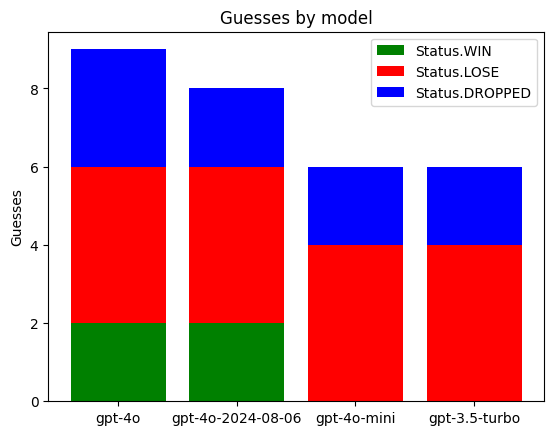

In [52]:


fig, ax = plt.subplots()

for model in models:
    win = result[model]["guesses"][Status.WIN]
    lose = result[model]["guesses"][Status.LOSE]
    dropped = result[model]["guesses"][Status.DROPPED]
    
    ax.bar(model, win, color='g')
    ax.bar(model, lose, bottom=win, color='r')
    ax.bar(model, dropped, bottom=win+lose, color='b')

ax.set_ylabel('Guesses')
ax.set_title('Guesses by model')
ax.legend([Status.WIN, Status.LOSE, Status.DROPPED])
plt.show()